# Project 3 report
Authors:
- Ignacy Stępka, 148179
- Michał Wiliński, 151938

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import pandas as pd
import dalex as dx
from xgboost import plot_tree
import os
from warnings import simplefilter as stfu
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

if "project3" in os.getcwd():
    os.chdir("..")
from project3.models import PrefXGB, load_data, get_metric

stfu("ignore")

***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>Dataset</h1>
</div>

Our dataset of choice is **Employee Selection (ESL)** dataset which is descibed in this paper<sup>[1]</sup>. It contains information about people applying for certain jobs in industries. Psychologists figured out the values of four things about each person based on tests and interviews - a psychometric survey. 

The result is an ordinal score from 1 to 9, showing how good of a fit each person is for a certain type of job. These columns were normalized. Target is also on ordinal scale, but it was binarized with a schema [1-5=>class 0, 6-9=>class 1] (unsuitable/suitable). The dataset contains 488 instances, but only 213 unique ones after deduplication.

Summary:
- 4 numerical features
- 1 binary target (after binarization)
- 488 instances
- 213 unique instances

For the purpose of training and testing the models, we split the dataset into 80% training and 20% testing sets.

***
1. Ali Fallah Tehrani, Weiwei Cheng, and Eyke Hüllermeier. "Choquistic regression: generalizing logistic regression using the Choquet integral". In *Proceedings of the 7th Conference of the European Society for Fuzzy Logic and Technology*, edited by Sylvie Galichet, Javier Montero, and Gilles Mauris, 868-875. Aix-Les-Bains, France: Atlantis Press, July 2011.


***

**Original datacard from WEKA**
```plaintext
1. Title: Employee Selection (Ordinal ESL)

2. Source Informaion:
   Donor: Arie Ben David
           MIS, Dept. of Technology Management 
           Holon Academic Inst. of Technology
           52 Golomb St.
           Holon 58102
           Israel
           abendav@hait.ac.il
    Owner: Yoav Ganzah
           Business Administration School
           Tel Aviv Univerity
           Ramat Aviv 69978
           Israel
 
3. Past Usage:

4. Relevant Information 
The ESL data set contains 488 profiles of applicants for certain industrial
jobs.  Expert psychologists of a recruiting company, based upon psychometric
test results and interviews with the candidates, determined the values of the
input attributes. The output is the an overall score corresponding to the
degree of fitness of the candidate to this type of job.


5. Number of Instances: 488

6. Number of Attributes: 4 input, 1 output.

7. Attribute Information: All input and output values are ORDINAL. 

8. Missing Attribute Values: None.
```

In [2]:
DATA_PATH = "project3/data/employee selection.csv"
ROUNDING = 2
TARGET_MAP = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1}
NO_CRITERIA = 4

In [3]:
dataset = pd.read_csv(DATA_PATH, header=None)
dataset.head()

,0,1,2,3,4
0,0.666667,0.555556,0.666667,0.666667,6.0
1,0.555556,0.444444,0.500000,0.500000,5.0
2,0.555556,0.333333,0.333333,0.500000,4.0
3,0.666667,0.555556,0.666667,0.833333,6.0
4,0.444444,0.333333,0.166667,0.500000,3.0


In [4]:
dataset.describe()

,0,1,2,3,4
count,488.000000,488.000000,488.000000,488.000000,488.000000
mean,0.611794,0.564891,0.557377,0.601776,5.229508
std,0.169549,0.172336,0.189287,0.156250,1.421668
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.527778,0.444444,0.500000,0.500000,4.000000
50%,0.666667,0.555556,0.500000,0.666667,5.000000
75%,0.666667,0.666667,0.666667,0.666667,6.000000
max,1.000000,1.000000,1.000000,1.000000,9.000000


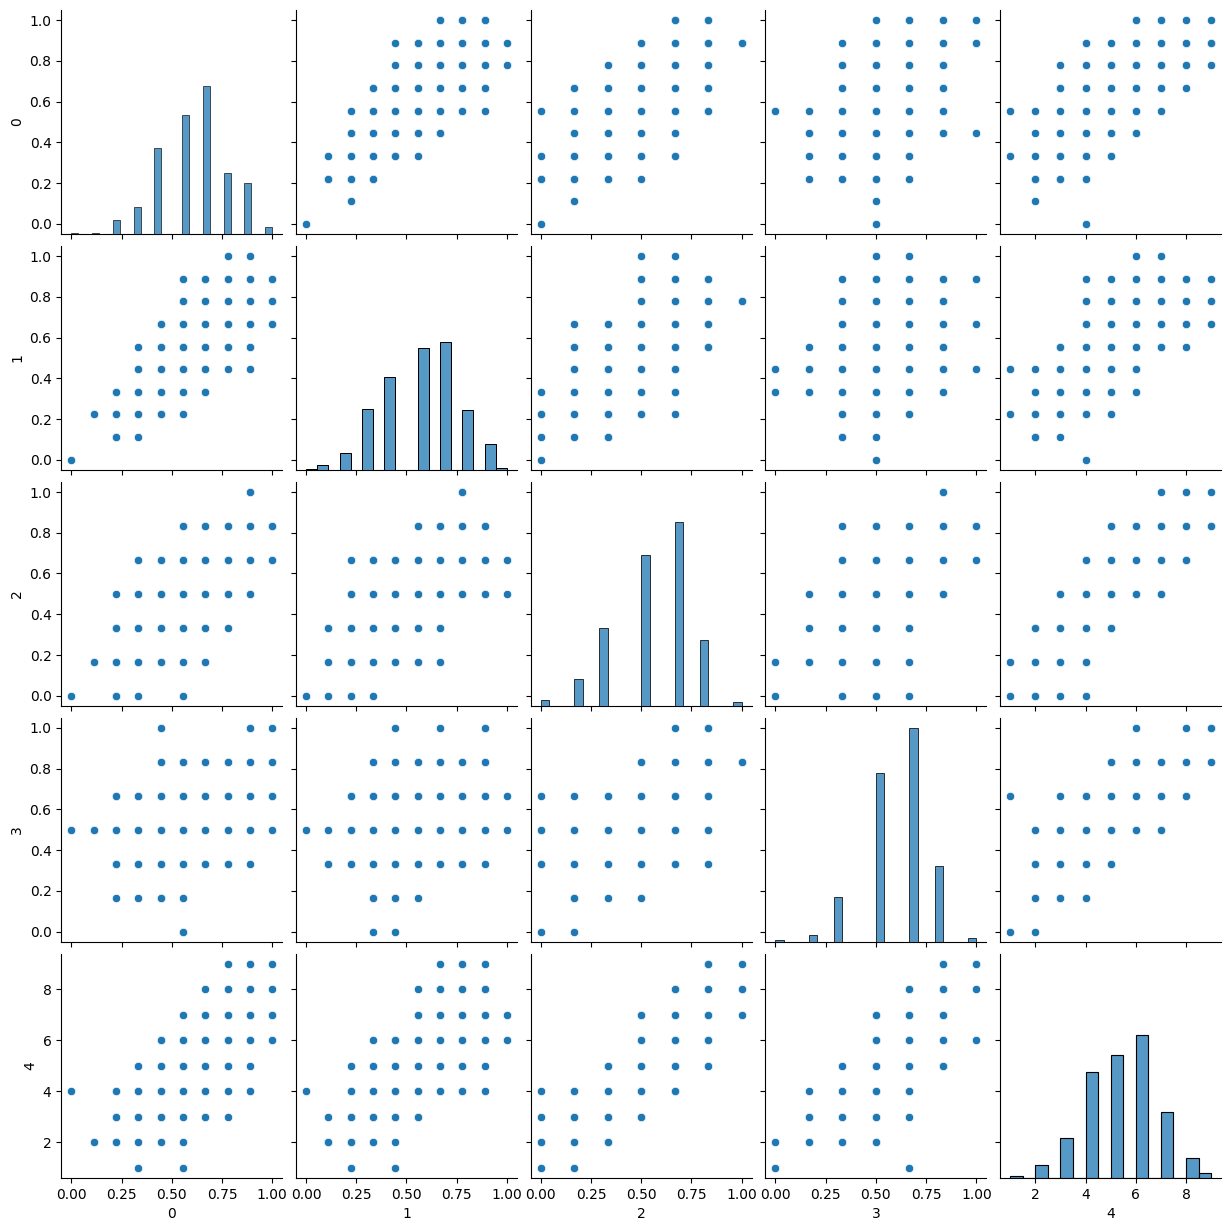

In [5]:
sns.pairplot(dataset)

<Axes: >

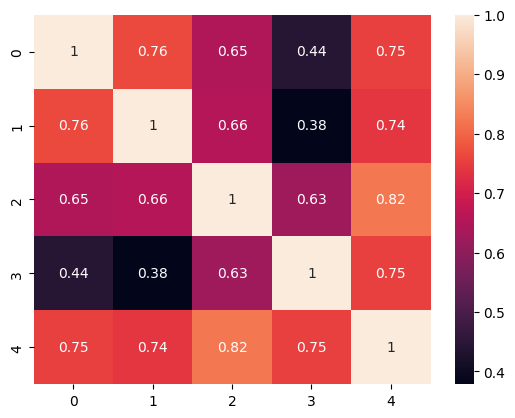

In [6]:
corr = dataset.corr()
sns.heatmap(corr, annot=True)

***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>1. Interpretable ML model - XGBoost</h1>
</div>

First model that we looked into was **XGBoost**. It is a popular and powerful gradient boosting algorithm that is widely used in machine learning competitions. It is known for its speed and performance. We used the implementation from the `xgboost` library.


<div style="background-color: #553300; color: white; text-align: center">
    <h2>1.1 Training & evaluating the model </h2>
</div>

Below we defined the params used for training the model. We used the `XGBClassifier` class from the `xgboost` library. We trained the model on the training set and evaluated it on the test set using accuracy, ROC AUC and F1 score metrics.

Compared to the hyperparameters from the classes, we increased `eta` from 0.1 to 0.3. `n_estimators` stayed the same as in the second set of hyperparams, keeping the model still interpretable because we will analyze 3 trees.

In [7]:
xgb_params = {
    "max_depth": NO_CRITERIA * 2,  # Maximum depth of a tree
    "eta": 0.3,  # Learning rate
    "nthread": 2,  # Number of parallel threads
    "seed": 0,  # Random seed
    "eval_metric": "rmse",  # Evaluation metric
    "monotone_constraints": "("
    + ",".join(["1"] * NO_CRITERIA)
    + ")",  # Monotonic constraints for each criterion (1 = increasing, -1 = decreasing, 0 = no constraint)
    "n_estimators": 3,  # Number of boosting rounds, or trees
}

In [8]:
xgb_results = dict()
pref_xgb = PrefXGB(xgb_params, criteria_nr=NO_CRITERIA)


X_train, X_test, y_train, y_test = load_data(DATA_PATH, TARGET_MAP, NO_CRITERIA)
pref_xgb.model.fit(X_train, y_train)

for metric in [accuracy_score, f1_score, roc_auc_score]:
    metric_train = get_metric(X_train, y_train, pref_xgb.model, metric)
    metric_test = get_metric(X_test, y_test, pref_xgb.model, metric)
    metric_train, metric_test = round(metric_train, ROUNDING), round(
        metric_test, ROUNDING
    )
    xgb_results[metric.__name__] = (metric_train, metric_test)

pprint(xgb_results)

{'accuracy_score': (0.88, 0.84),
 'f1_score': (0.85, 0.82),
 'roc_auc_score': (0.88, 0.84)}


<Axes: xlabel='Predicted', ylabel='Actual'>

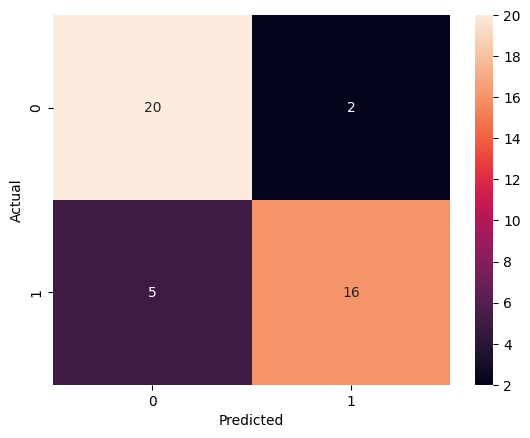

In [9]:
confusion_matrix = pd.crosstab(
    y_test, pref_xgb.model.predict(X_test), rownames=["Actual"], colnames=["Predicted"]
)
sns.heatmap(confusion_matrix, annot=True)

As visible above we, we achieved acceptable results in terms of each metric. The model is able to predict the target on test set with **0.77 accuracy, 0.76 ROC AUC and 0.72 F1 score**.

Confusion matrix shows that the model rarely misclassifies the target although small confusion still happens.

<div style="background-color: #553300; color: white; text-align: center">
    <h2>1.2 Interpretability</h2>
</div>

<div style="background-color: #554400; color: white; text-align: center">
    <h4>1.2.1 Estimator visualization</h4>
</div>

We decided that one of the ways to interpret our XGBoost model is to visualize the trees. Constrained number of estimators (3) allows us to do so. We used the `plot_tree` function from the `xgboost` library to visualize the trees.

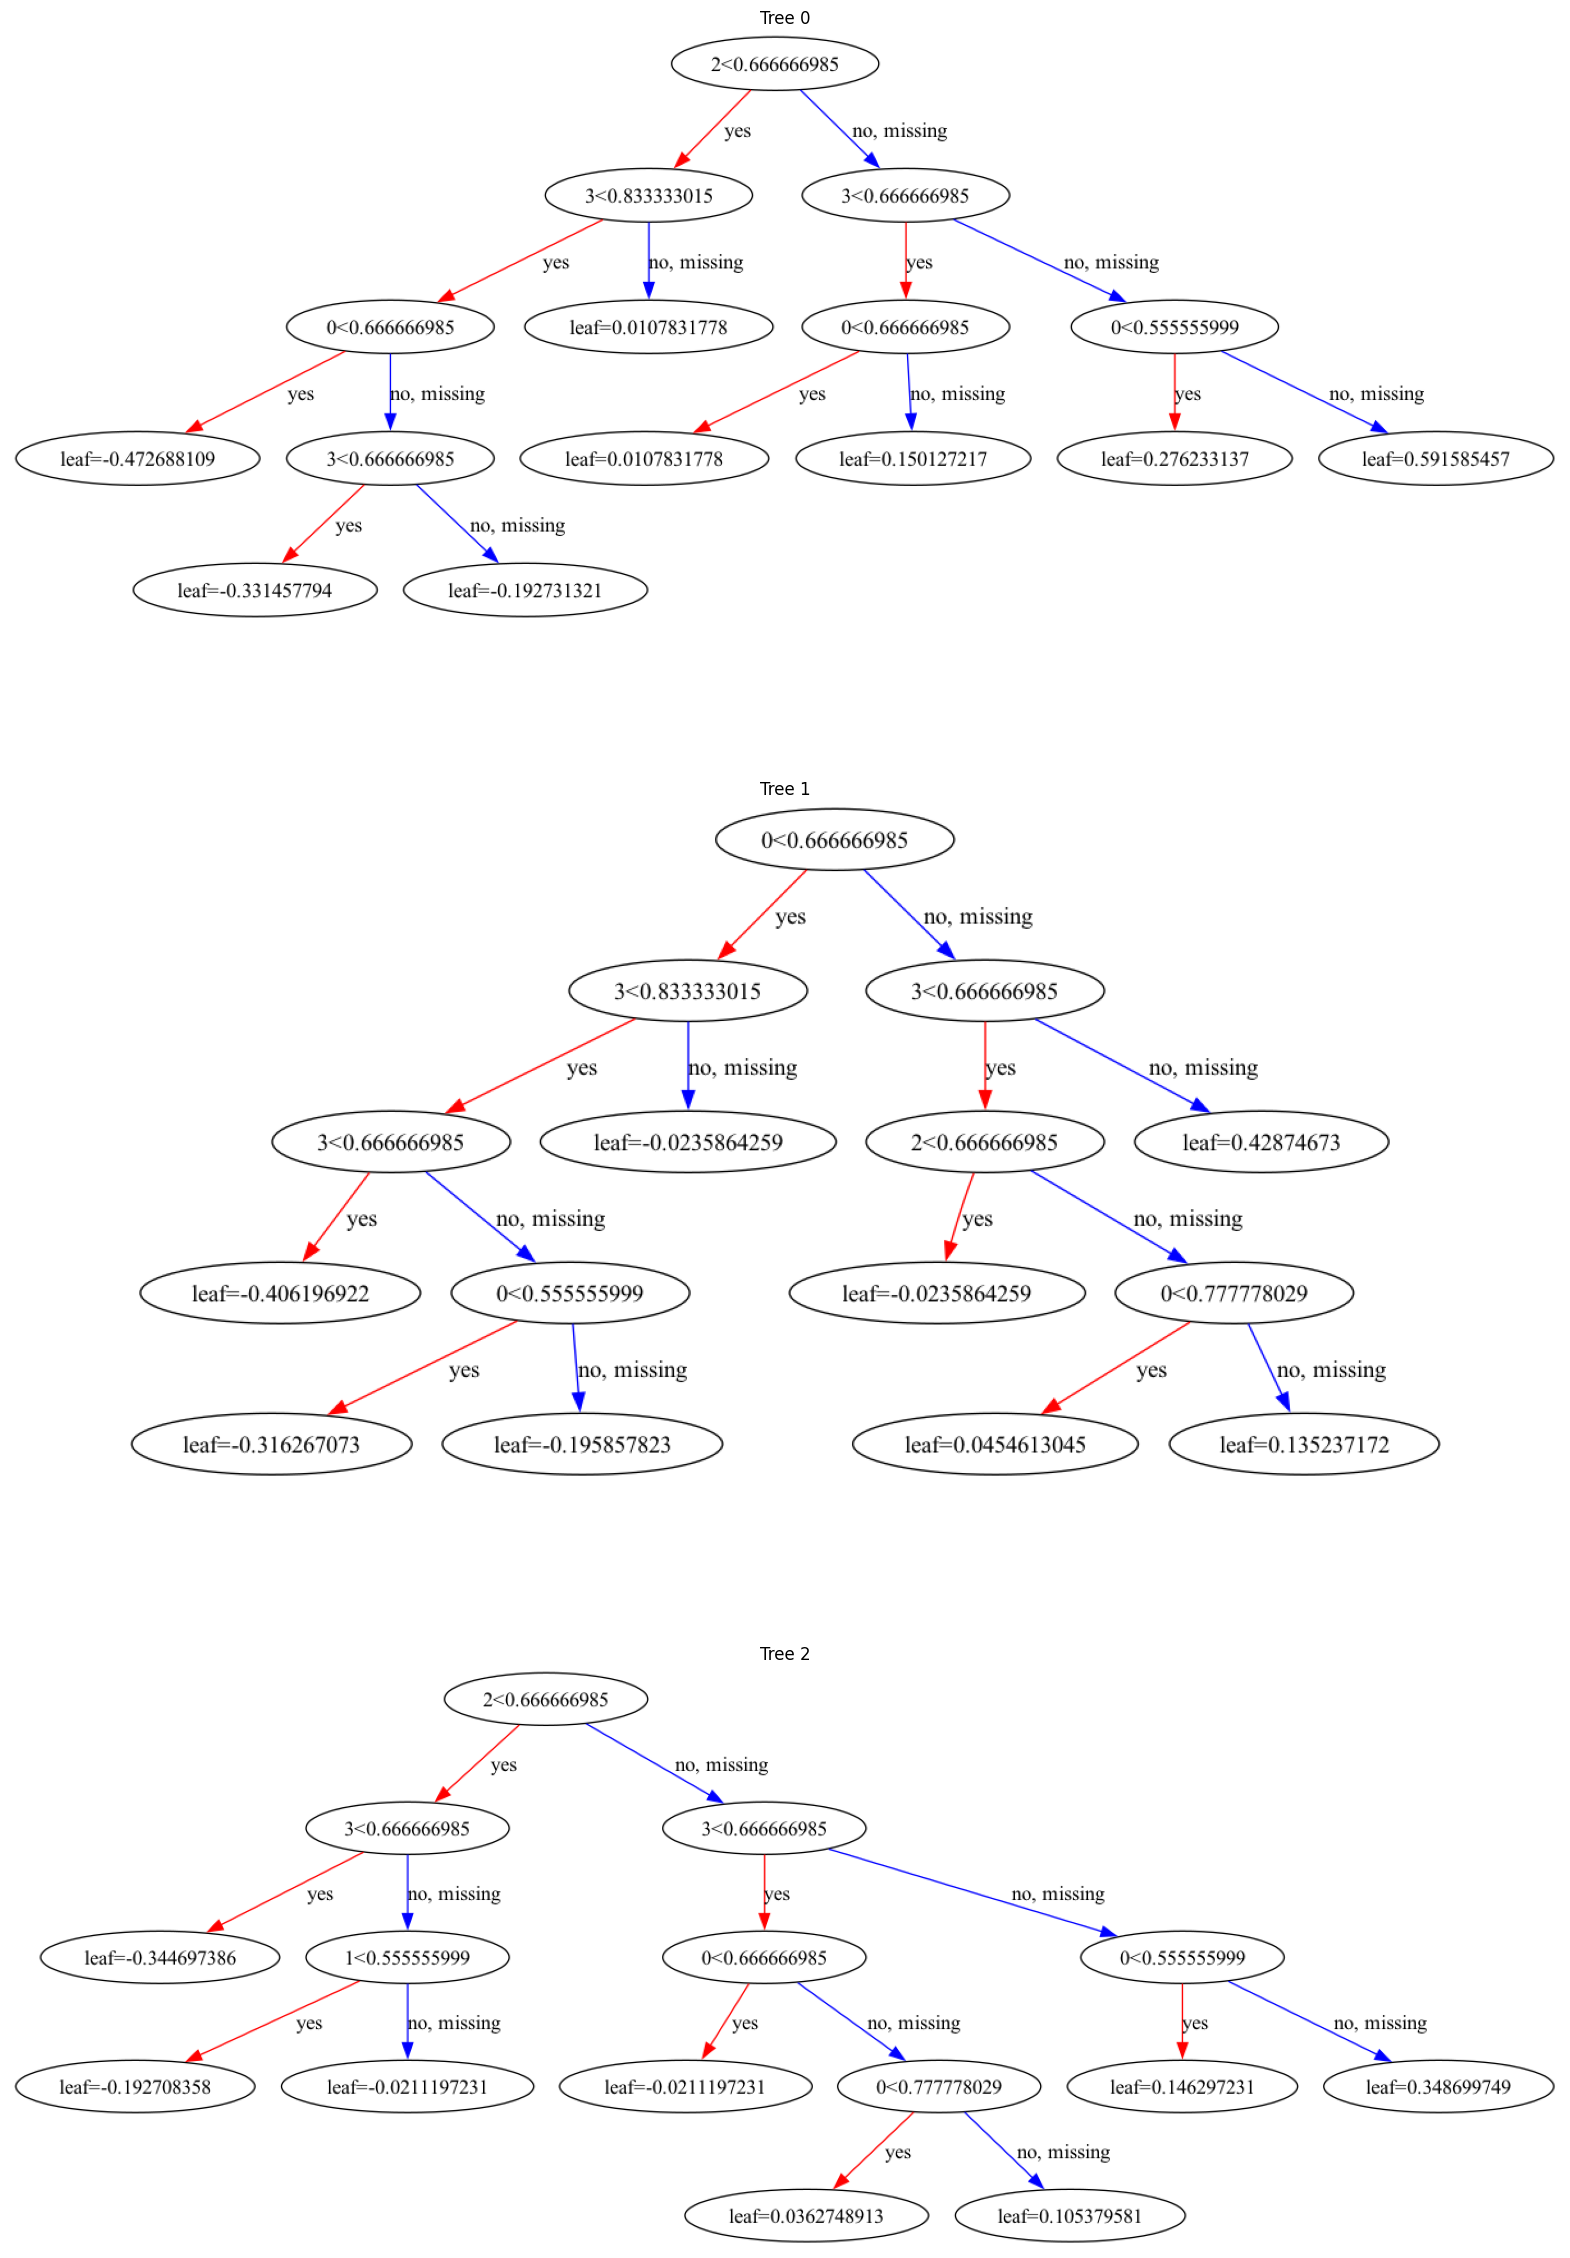

In [10]:
fig, axs = plt.subplots(xgb_params["n_estimators"], 1, figsize=(20, 30))

for i in range(xgb_params["n_estimators"]):
    ax = axs[i]
    plot_tree(pref_xgb.model, ax=ax, num_trees=i)
    ax.set_title(f"Tree {i}")
plt.show()

According to boosting algorithm, the trees are built sequentially, so the first tree is the most important one. Here, the first split is done at the criterion 2 as it is deemed the most informative. 

By taking a look at the correlation matrix, we can see that the most correlated criterion with the target (column 4 in the dataset) is criterion 2. This is why the first split in the first tree happens at this criterion.

Similar things happen with the rest of the criteria in the first tree, the order in which they are used is highly corresponds with the correlation matrix.

<div style="background-color: #554400; color: white; text-align: center">
    <h4>1.2.2 Feature importance</h4>
</div>

These methods simply output the importance of each feature in the model in different ways. 
We considered:
- fscore: the number of times a feature is used to split the data across all trees
- weight: the number of times a feature is used to split the data across all trees - the same as fscore
- gain: the average gain across all splits the feature is used in

In [11]:
booster = pref_xgb.model.get_booster()
booster.get_fscore()

{'0': 9.0, '1': 1.0, '2': 3.0, '3': 8.0}

In [12]:
booster.get_score(importance_type="gain")

{'0': 4.8098602294921875,
 '1': 2.056673765182495,
 '2': 27.987272262573242,
 '3': 6.7240118980407715}

The same conclusion about the second criterion comes from gain-based feature importance (frequency in splits). The criterion 2 is the most important one!

<div style="background-color: #554400; color: white; text-align: center">
    <h4>1.2.3 Partial dependence plots</h4>
</div>

The third interpretability method we used is partial dependence plots. They show the relationship between the target and a feature while keeping the other features constant. We used the `plot_partial_dependence` function from the `sklearn` library to plot the partial dependence plots.

We also investigate interactions between pairs of features.

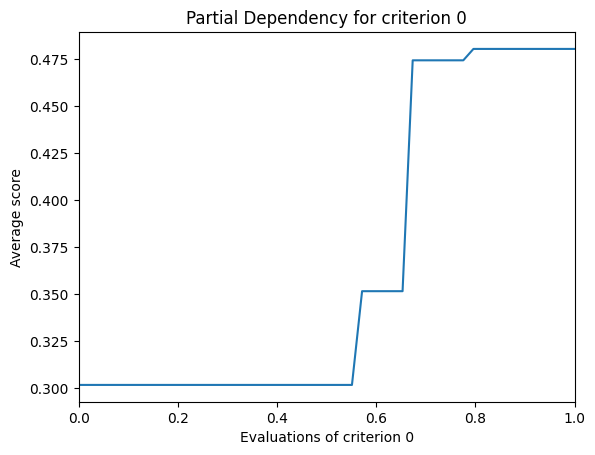

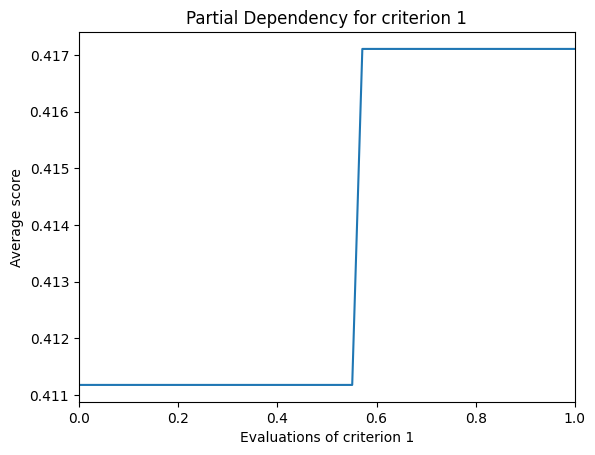

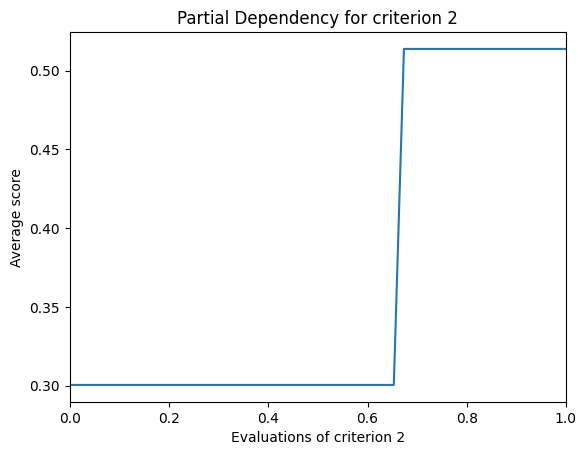

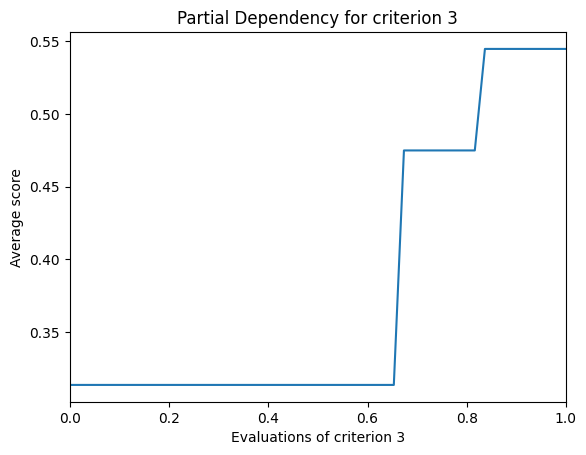

In [13]:
grid = np.linspace(0, 1, 100)
for c in range(NO_CRITERIA):
    grid, y_pred = pref_xgb.partial_dependency(X_train.values, y_train, c)
    fig, ax = plt.subplots()
    ax.plot(grid, y_pred)
    ax.set_xlim(0, 1)
    ax.set_title(f"Partial Dependency for criterion {c}")
    ax.set_xlabel(f"Evaluations of criterion {c}")
    ax.set_ylabel("Average score")

We can clearly see that all the criteria are of the **gain type**.

[0, 1, 2, 3, (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


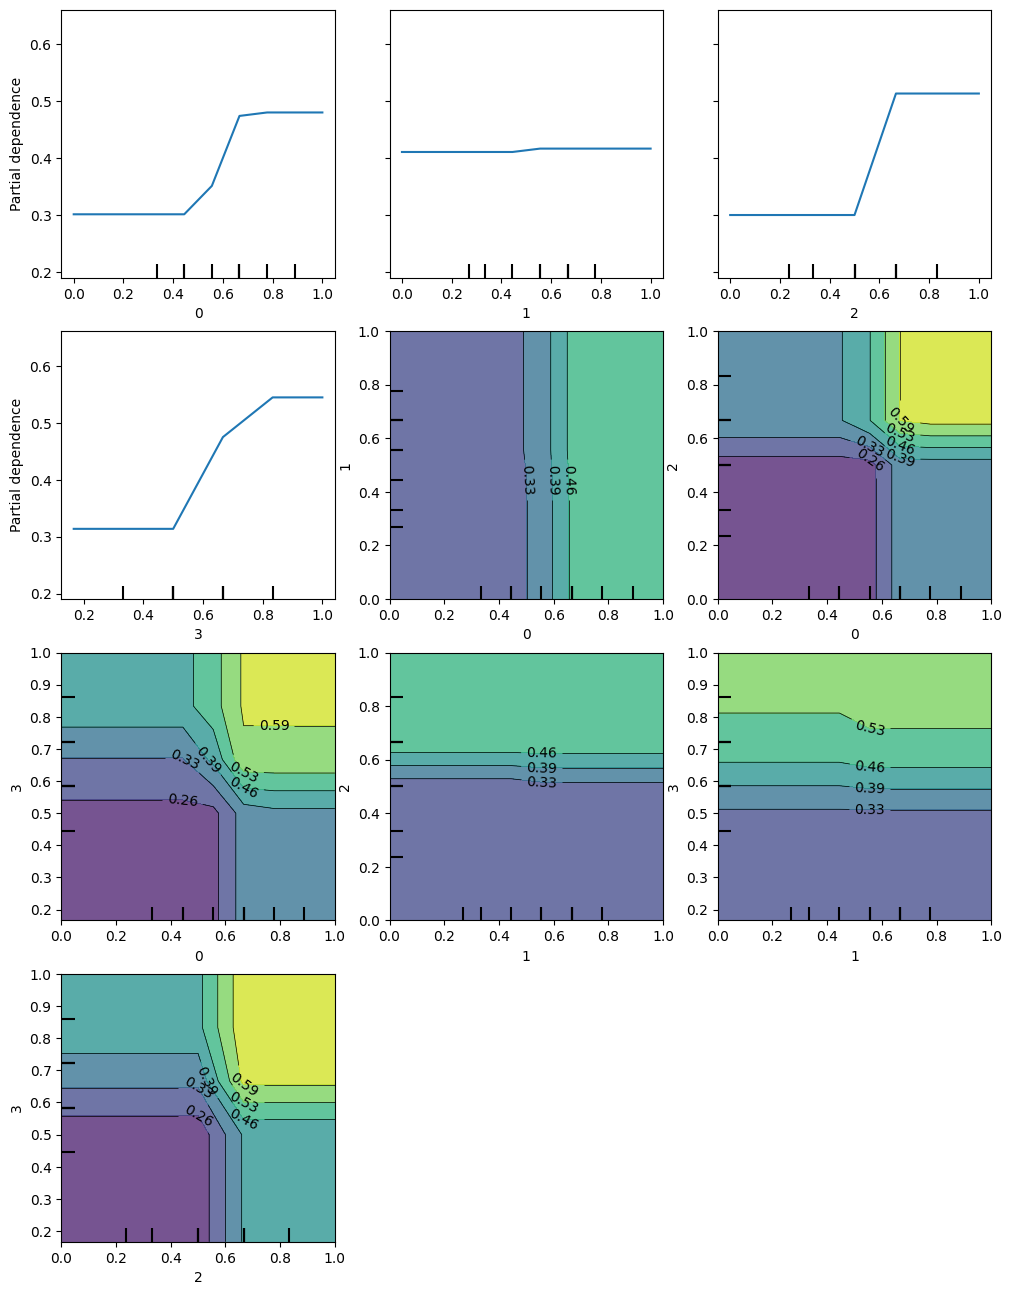

In [14]:
from itertools import combinations

features = list(range(NO_CRITERIA))
features += list(combinations(features, 2))
print(features)
fig, ax = plt.subplots(figsize=(12, 16))
PartialDependenceDisplay.from_estimator(pref_xgb.model, X_train, features, ax=ax)

We can see that criterion 1 is not that informative, compared to others, and the criteria interactions correspond pretty much with the correlation matrix.

<div style="background-color: #554400; color: white; text-align: center">
    <h4>1.2.4 Permutation importance</h4>
</div>

The last interpretability method we used is permutation importance. It is a model-agnostic method that measures the importance of a feature by shuffling its values and measuring the drop in the model's performance. We used the `permutation_importance` function from the `sklearn` library to calculate the permutation importance.

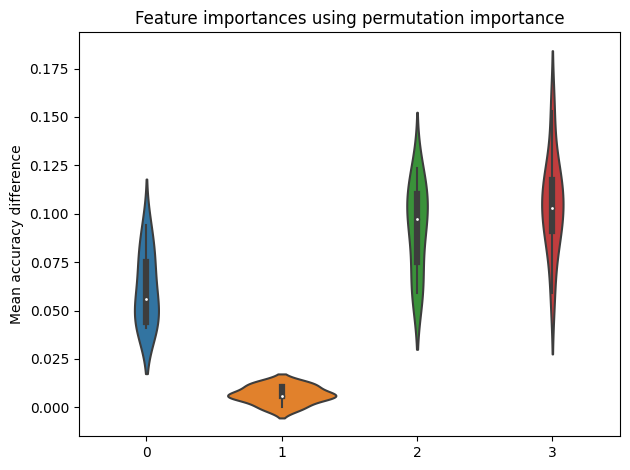

In [15]:
permutation_importance_output = permutation_importance(
    pref_xgb.model, X_train, y_train, n_repeats=10, random_state=0
)
fig, ax = plt.subplots()
sns.violinplot(pd.DataFrame(permutation_importance_output.importances.T), ax=ax)
ax.set_title("Feature importances using permutation importance")
ax.set_ylabel("Mean accuracy difference")
fig.tight_layout()

Again, proof for the non-informativeness of criterion 1 is visible. The most important criterion is the second/third one here, so it partly corresponds to the gain-based feature importance.

<div style="background-color: #553300; color: white; text-align: center">
    <h2>1.3 Local decision explanation</h2>
</div>

In [16]:
def explain_samples(samples, explainer):
    explanations = []
    for i in range(len(samples)):
        sample = samples.iloc[i]
        sample = sample.to_frame().T
        prediction = pref_xgb.model.predict(sample)
        sample_explanation = explainer.predict_surrogate(sample)
        explanations.append((sample, prediction, sample_explanation))
    return explanations

NO_SAMPLES = 3
RANDOM_STATE = 1
sample = X_test.sample(NO_SAMPLES, random_state=RANDOM_STATE)
pprint(sample)

            0         1         2         3
231  0.888889  0.777778  0.666667  0.833333
6    0.555556  0.555556  0.500000  0.500000
34   0.777778  0.888889  0.666667  0.500000


In [17]:
explainer = dx.Explainer(pref_xgb.model, X_train, y_train)
explanations = explain_samples(sample, explainer)

Preparation of a new explainer is initiated

  -> data              : 170 rows 4 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 170 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x162b52ca0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.168, mean = 0.414, max = 0.73
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.73, mean = -0.0084, max = 0.746
  -> model_info        : package xgboost

A new explainer has been created!


### Sample 1

,0,1,2,3
231,0.888889,0.777778,0.666667,0.833333


Prediction: [1]


,variable,effect
0,0.50 < 2 <= 0.67,0.165317
1,3 > 0.67,0.148400
2,0 > 0.78,0.141946
3,1 > 0.67,0.002968


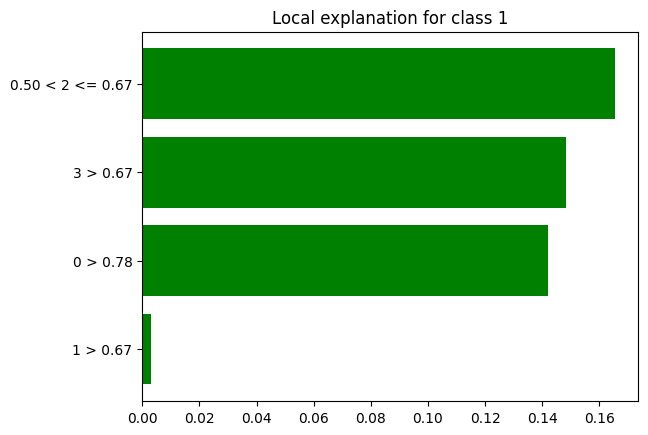

In [18]:
display(explanations[0][0])
print(f"Prediction: {explanations[0][1]}")
explanations[0][2].plot()
display(explanations[0][2].result)

Here, there's no single criterion that would change the whole prediction. We would have to flip multiple criteria values.

### Sample 2

,0,1,2,3
6,0.555556,0.555556,0.5,0.5


Prediction: [0]


,variable,effect
0,3 <= 0.50,-0.166120
1,0.33 < 2 <= 0.50,-0.130469
2,0.44 < 0 <= 0.67,-0.054009
3,0.44 < 1 <= 0.56,0.001251


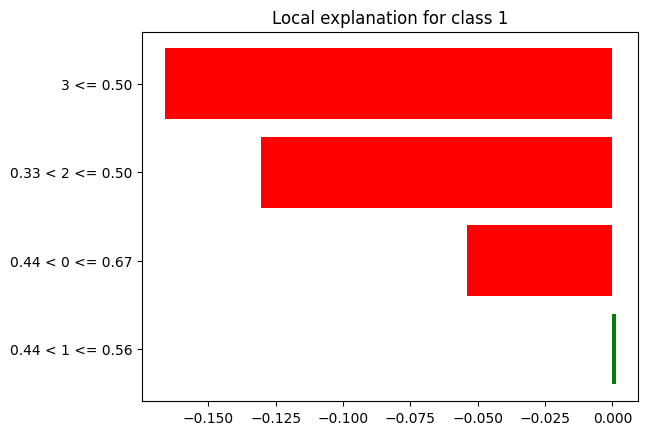

In [19]:
display(explanations[1][0])
print(f"Prediction: {explanations[1][1]}")
explanations[1][2].plot()
display(explanations[1][2].result)

In this case changing the value of criterion 3 would have the greates impact on the prediction. But no single crietion can be changed to flip the prediction.

### Sample 3

,0,1,2,3
34,0.777778,0.888889,0.666667,0.5


Prediction: [1]


,variable,effect
0,3 <= 0.50,-0.170624
1,0.50 < 2 <= 0.67,0.162553
2,0.67 < 0 <= 0.78,0.141366
3,1 > 0.67,-0.000316


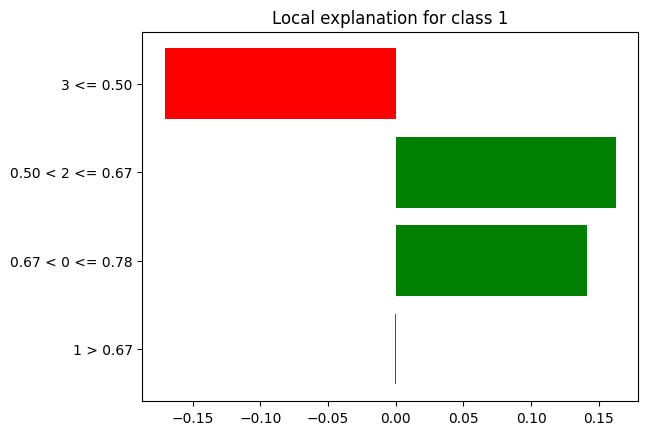

In [20]:
display(explanations[2][0])
print(f"Prediction: {explanations[2][1]}")
explanations[2][2].plot()
display(explanations[2][2].result)

Here flipping either 2 or 0th criterion would change the prediction.

***


<div style="background-color: #993300; color: white; text-align: center">
    <h1>2. Interpretable neural MCDA method - ANN-UTADIS</h1>
</div>


In [21]:
from project3.models.ann_utadis.utils import *
from project3.models.ann_utadis.uta import Uta
from project3.models.ann_utadis.norm_layer import NormLayer

<div style="background-color: #553300; color: white; text-align: center">
    <h2>2.1 Training & evaluating the model</h2>
</div>

In [22]:
MODEL_SAVE_PATH = "project3/weights/ann_utadis.pt2"

In [23]:
X_train_pt = X_train.values.reshape(-1, 1, NO_CRITERIA)
X_test_pt = X_test.values.reshape(-1, 1, NO_CRITERIA)
y_train_pt = y_train.values
y_test_pt = y_test.values
print(X_train_pt.shape, X_test_pt.shape)
print(y_train_pt.shape, y_test_pt.shape)

(170, 1, 4) (43, 1, 4)
(170,) (43,)


In [24]:
train_dataloader = CreateDataLoader(X_train_pt, y_train_pt)
test_dataloader = CreateDataLoader(X_test_pt, y_test_pt)

In [25]:
uta = Uta(NO_CRITERIA, 30)
model = NormLayer(uta, NO_CRITERIA)
(
    best_acc,
    best_auc,
    best_f1,
    stats_train,
    stats_test,
) = Train(
    model,
    train_dataloader,
    test_dataloader,
    MODEL_SAVE_PATH,
    epoch_nr=200,
    lr=0.0001,
    slope_decrease=True,
)
print(f"Best accuracy: {best_acc:.2f}")
print(f"Best AUC: {best_auc:.2f}")
print(f"Best F1: {best_f1:.2f}")

100%|██████████| 200/200 [00:00<00:00, 314.64it/s]

Best accuracy: 0.91
Best AUC: 0.97
Best F1: 0.89


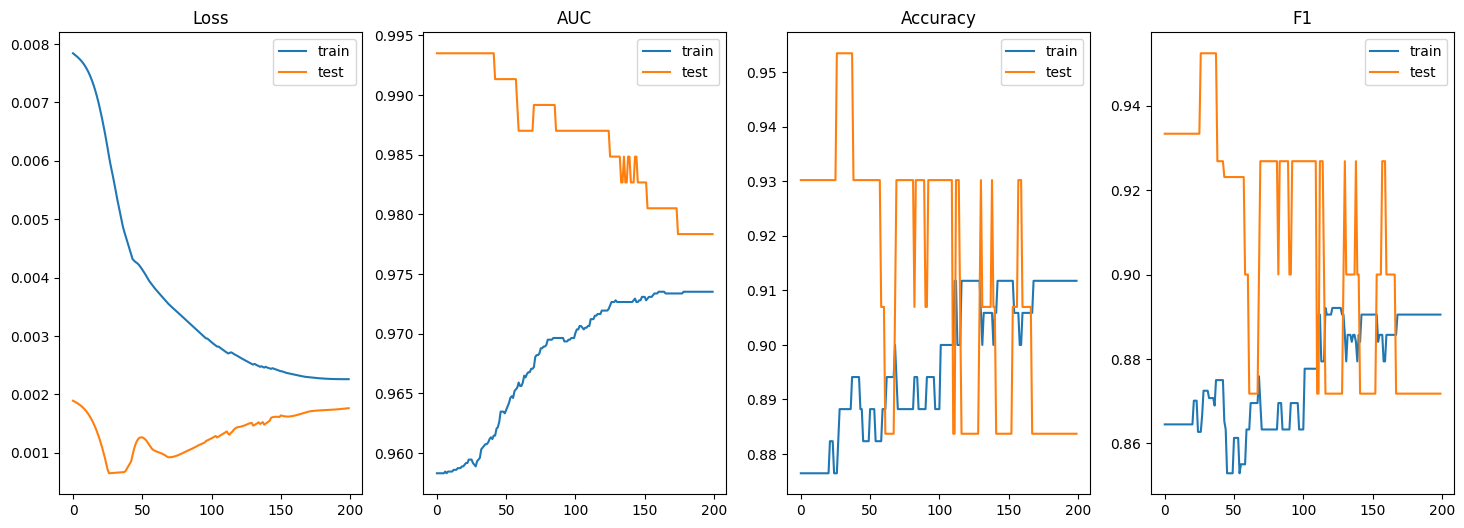

In [26]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(141)
ax.plot(stats_train.losses, label="train")
ax.plot(stats_test.losses, label="test")
ax.set_title("Loss")
ax.legend()

ax = fig.add_subplot(1, 4, 2)
ax.plot(stats_train.auc_scores, label="train")
ax.plot(stats_test.auc_scores, label="test")
ax.set_title("AUC")
ax.legend()

ax = fig.add_subplot(1, 4, 3)
ax.plot(stats_train.acc_scores, label="train")
ax.plot(stats_test.acc_scores, label="test")
ax.set_title("Accuracy")
ax.legend()

ax = fig.add_subplot(1, 4, 4)
ax.plot(stats_train.f1_scores, label="train")
ax.plot(stats_test.f1_scores, label="test")
ax.set_title("F1")
ax.legend()

<div style="background-color: #553300; color: white; text-align: center">
    <h2>2.2 Interpretability</h2>
</div>

Interpretability in ANN-UTADIS is achieved by design. We can infer the learned utility functions from the weights of the network, to be exact - from the shape of utility functions that arose in the monotone blocks, right after the input.

In [27]:
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [28]:
hook = Hook(model.method_instance.monotonic_layer, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = get_simple_input(val, NO_CRITERIA)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
outs = outs[::3] - outs[::3][0]
outs = outs / outs[-1].sum()

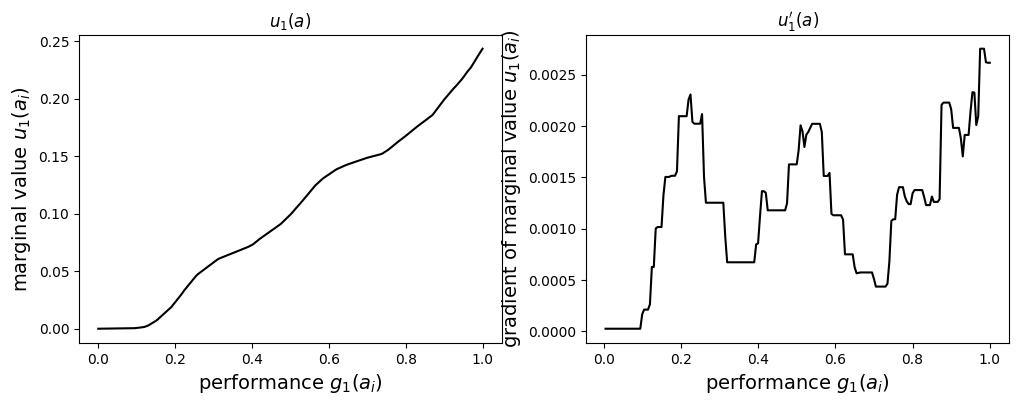

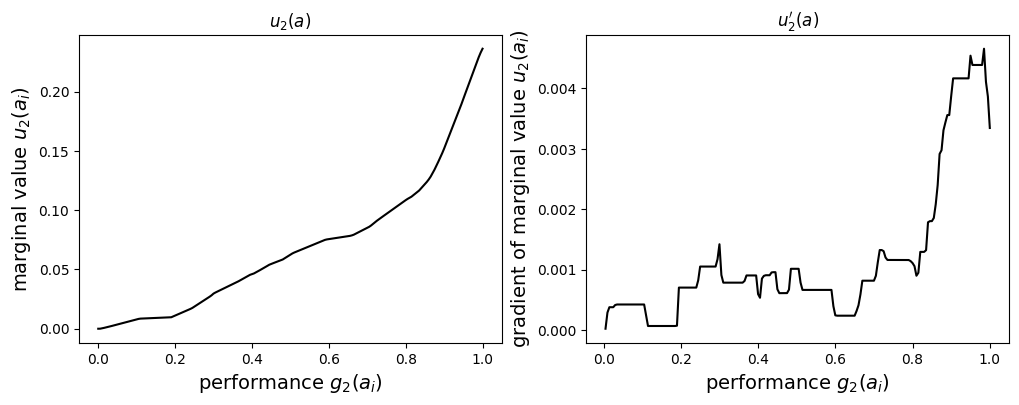

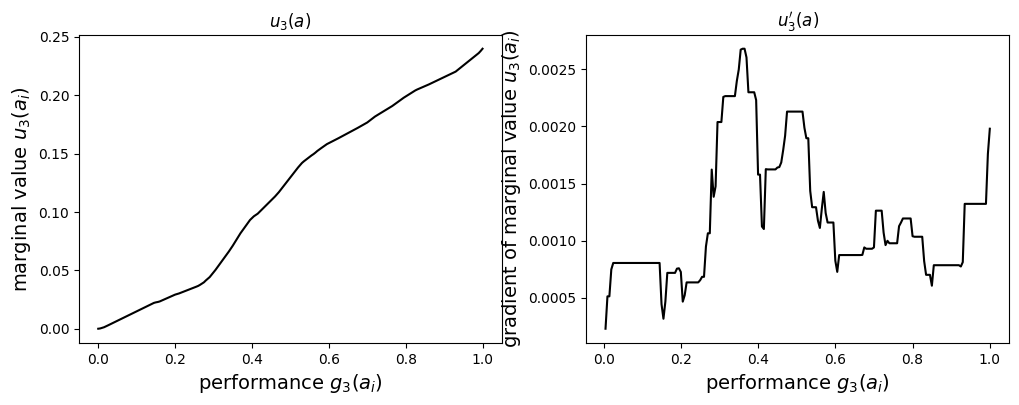

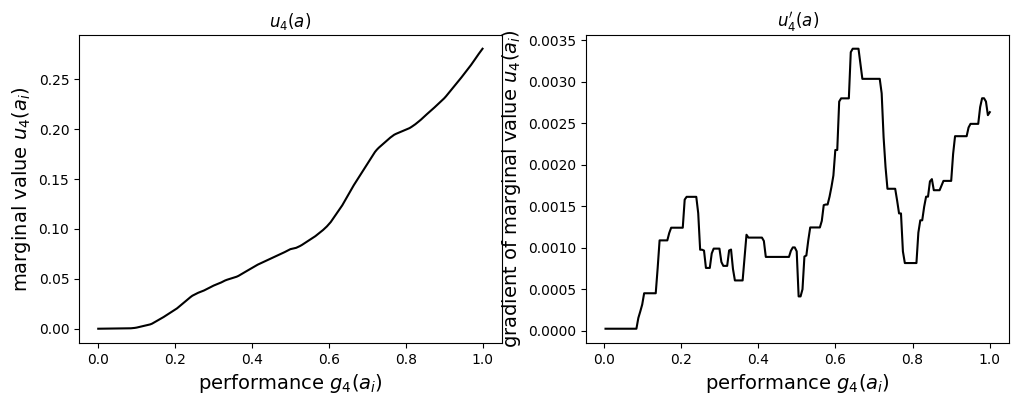

In [29]:
for i in range(NO_CRITERIA):
    criterion_number = i + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(121)
    ax.set_title(f"$u_{criterion_number}(a)$")
    ax.plot(xs, outs[:, i], color="black")
    ax.set_ylabel(f"marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(f"$u_{criterion_number}'(a)$")
    ax.plot(xs[1:], outs[1:, i] - outs[:-1, i], color="black")
    ax.set_ylabel(
        f"gradient of marginal value $u_{criterion_number}(a_i)$", fontsize=14
    )
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)
    plt.show()

This method also highlights that all criteria are of gain type, we can here also observe the different behaviour of marginal utility value for different performances on the criteria.

<div style="background-color: #553300; color: white; text-align: center">
    <h2>2.3 Local decision explanation</h2>
</div>

In [40]:
NO_SAMPLES = 3
RANDOM_STATE = 1
sample = X_test.sample(NO_SAMPLES, random_state=RANDOM_STATE)
pprint(sample)

# make it a list of numpy arrays
sample = [sample.iloc[i].values for i in range(NO_SAMPLES)]

            0         1         2         3
231  0.888889  0.777778  0.666667  0.833333
6    0.555556  0.555556  0.500000  0.500000
34   0.777778  0.888889  0.666667  0.500000


In [41]:
def predict(model, tensor):
    model.eval()
    with torch.no_grad():
        out = model(tensor).item() + 0.5
    return out

In [43]:
# predictions = [predict(model, tensor) for tensor in sample]
# predictions

explainer = dx.Explainer(model, X_train_pt.reshape(-1, NO_CRITERIA), y_train_pt, predict_function=predict)

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 170 rows 4 cols
  -> target variable   : 170 values
  -> model_class       : project3.models.ann_utadis.norm_layer.NormLayer (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function predict at 0x34f67b1a0> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> model type        : 'model_type' not provided and cannot be extracted.
  -> model type        : Some functionalities won't be available.
  -> residual function : difference between y and yhat (default)
  -> residuals         :  'residual_function' returns an Error when executed:
'DataFrame' object has no attribute 'view'
  -> model_info        : package project3

A new explainer has been created!


In [44]:
print(sample)

[array([0.888889, 0.777778, 0.666667, 0.833333]), array([0.555556, 0.555556, 0.5     , 0.5     ]), array([0.777778, 0.888889, 0.666667, 0.5     ])]


In [47]:
explanations = explainer.predict_surrogate(sample[0], mode="classification")

ValueError: Pass a proper `predict_fn` parameter to the `predict_surrogate` method. See https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer.explain_instance

In [ ]:
display(explanations[0][0])
print(f"Prediction: {explanations[0][1]}")
explanations[0][2].plot()
display(explanations[0][2].result)

***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>3. Neural network with a few layers & nonlinear activation functions</h1>
</div>


<div style="background-color: #553300; color: white; text-align: center">
    <h2>3.1 Training & evaluating the model</h2>
</div>

In [ ]:
from project3.models.preference_net import train_model, test_model

In [ ]:
preference_nn_params = {
    "input_size": 4,
    "hidden_size": 8,
    "num_epochs": 200,
    "learning_rate": 0.01,
    "path": "project3/weights/preference_net.pth",
}

model = train_model(train_dataloader, test_dataloader, **preference_nn_params)
print("TRAIN SET PERFORMANCE")
test_model(model, train_dataloader)
print()
print("TEST SET PERFORMANCE")
test_model(model, test_dataloader)

100%|██████████| 200/200 [00:00<00:00, 445.11it/s, Loss=0.218, Test Accuracy=0.86] 


TRAIN SET PERFORMANCE
Accuracy Score: 0.9235
F1 Score: 0.9051
ROC AUC: 0.9196
Precision-Recall AUC: 0.9257

TEST SET PERFORMANCE
Accuracy Score: 0.8605
F1 Score: 0.8500
ROC AUC: 0.8593
Precision-Recall AUC: 0.8986


<div style="background-color: #553300; color: white; text-align: center">
    <h2>3.2 Interpretability</h2>
</div>

<div style="background-color: #553300; color: white; text-align: center">
    <h2>3.3 Local decision explanation</h2>
</div>

In [ ]:
NO_SAMPLES = 3
RANDOM_STATE = 2
sample = X_test.sample(NO_SAMPLES, random_state=RANDOM_STATE)
pprint(sample)

            0         1         2         3
137  0.555556  0.333333  0.500000  0.833333
62   0.666667  0.444444  0.666667  0.666667
316  0.555556  0.666667  0.500000  0.666667


In [ ]:
explainer = dx.Explainer(pref_xgb.model, X_train, y_train) # TODO CHANGE
explanations = explain_samples(sample, explainer)

In [ ]:
display(explanations[0][0])
print(f"Prediction: {explanations[0][1]}")
explanations[0][2].plot()
display(explanations[0][2].result)

***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>Final conclusions</h1>
</div>
